# GBD continuous risk curves for simulation

## Setup

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # it would be great to update vivarium to make this unnecessary!

In [2]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

Tue Jun 18 16:13:30 PDT 2024


In [3]:
# the Artifact class is defined in the base vivarium module
import vivarium as vi

# and to get the data for the artifact, we will use vivarium_inputs and gbd_mapping
# note that vivarium_inputs only works when on the IHME VPN at present
import vivarium_inputs as vii, gbd_mapping

import vivarium_gbd_access.gbd
import scipy

Config: 'input_data:
    cache_data:
        base: True
    intermediary_data_cache_path:
        base: /share/scratch/users/{username}/cache'
Cache Dir: '/share/scratch/users/zmbc/cache'


In [4]:
# Replace with your risk of interest
risk = gbd_mapping.risk_factors.diet_high_in_sodium
# Replace with your cause of interest
cause = gbd_mapping.causes.stomach_cancer
location = 'Washington'
age_group = '75 to 79'
is_harmful = True
sex = 'Male'
year = 2021

In [5]:
risk.tmred

Tmred(
distribution='uniform',
inverted=False,
min=scalar(1.000000),
max=scalar(5.000000))

In [6]:
from db_queries import get_ids

def get_id_by_name(entity_type, name):
    id_table = get_ids(entity_type)
    name_col = f"{entity_type}_name"
    if name_col not in id_table.columns:
        name_col = entity_type
    matching = id_table[id_table[name_col] == name]
    assert len(matching) == 1
    return matching[f"{entity_type}_id"].iloc[0]

location_id = get_id_by_name("location", location)
age_group_id = get_id_by_name("age_group", age_group)
sex_id = get_id_by_name("sex", sex)

## Create relative risk curves

In [7]:
relative_risk_data = vivarium_gbd_access.gbd.get_relative_risk(
    risk.gbd_id,
    location_id,
    2021
)
relative_risk_data

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,124,9045,1,2021,10,1,414,1,1,3,...,1.482551,1.200242,1.282695,1.187667,1.343606,1.178416,1.400630,1.444359,1.311811,1.225838
1,124,9045,1,2021,11,1,414,1,1,3,...,1.482551,1.200242,1.282695,1.187667,1.343606,1.178416,1.400630,1.444359,1.311811,1.225838
2,124,9045,1,2021,12,1,414,1,1,3,...,1.482551,1.200242,1.282695,1.187667,1.343606,1.178416,1.400630,1.444359,1.311811,1.225838
3,124,9045,1,2021,13,1,414,1,1,3,...,1.482551,1.200242,1.282695,1.187667,1.343606,1.178416,1.400630,1.444359,1.311811,1.225838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,124,9045,1,2021,30,2,414,1,1,3,...,2.744482,1.596766,1.893317,1.554223,2.132473,1.523375,2.372284,2.566847,2.005472,1.685538
29997,124,9045,1,2021,31,2,414,1,1,3,...,2.744482,1.596766,1.893317,1.554223,2.132473,1.523375,2.372284,2.566847,2.005472,1.685538
29998,124,9045,1,2021,32,2,414,1,1,3,...,2.744482,1.596766,1.893317,1.554223,2.132473,1.523375,2.372284,2.566847,2.005472,1.685538
29999,124,9045,1,2021,235,2,414,1,1,3,...,2.744482,1.596766,1.893317,1.554223,2.132473,1.523375,2.372284,2.566847,2.005472,1.685538


In [8]:
# Subset to cause, age, and sex of interest
# If interested in multiple, would loop through them
relative_risk_data = relative_risk_data[
    (relative_risk_data.cause_id == cause.gbd_id) &
    (relative_risk_data.age_group_id == age_group_id) &
    (relative_risk_data.sex_id == sex_id)
].sort_values('exposure')

relative_risk_functions_no_clipping = {}
relative_risk_functions_clipping = {}

# Do calculation at the draw level
for draw_id in range(1_000):
    relative_risk_draw = relative_risk_data[f'draw_{draw_id}']
    # interpolate a continuous function between the points,
    # and extrapolate outside the range with the endpoints
    raw_relative_risk_function = scipy.interpolate.interp1d(
        relative_risk_data.exposure,
        relative_risk_draw,
        kind='linear',
        bounds_error=False,
        fill_value=(
            relative_risk_draw.min(),
            relative_risk_draw.max(),
        )
    )

    # pick a tmrel between tmred.min and tmred.max and calculate relative risk at tmrel
    # for certain risk factors, the modeling team uploads a model for this with TMREL draws --
    # those should be used instead of this, when available!
    tmrel = np.random.uniform(risk.tmred.min, risk.tmred.max)
    rr_at_tmrel = raw_relative_risk_function(tmrel)
    normalized_relative_risk_draw = relative_risk_draw / rr_at_tmrel

    # The above normalization can result in RRs less than 1, which could in some
    # cases imply a negative PAF.
    # Clip relative risk to 1, since the TMREL is supposed to represent minimum risk
    # NOTE: It is not clear if this is appropriate, since TMRELs are across all
    # risk-cause pairs involving this risk, not only the pair we are modeling
    # TODO: Follow up with GBD about this
    if is_harmful:
        clipped_normalized_relative_risk_draw = np.clip(normalized_relative_risk_draw, 1.0, np.inf)
    else:
        clipped_normalized_relative_risk_draw = np.clip(normalized_relative_risk_draw, -np.inf, 1.0)

    relative_risk_function = scipy.interpolate.interp1d(
        relative_risk_data.exposure,
        clipped_normalized_relative_risk_draw,
        kind='linear',
        bounds_error=False,
        fill_value=(
            clipped_normalized_relative_risk_draw.min(),
            clipped_normalized_relative_risk_draw.max(),
        )
    )

    relative_risk_functions_no_clipping[draw_id] = scipy.interpolate.interp1d(
        relative_risk_data.exposure,
        normalized_relative_risk_draw,
        kind='linear',
        bounds_error=False,
        fill_value=(
            normalized_relative_risk_draw.min(),
            normalized_relative_risk_draw.max(),
        )
    )
    relative_risk_functions_clipping[draw_id] = relative_risk_function

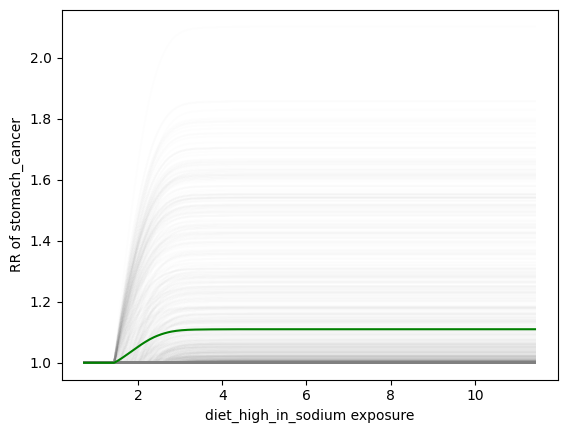

In [9]:
# Plot the relative risk functions
x_values = np.linspace(relative_risk_data.exposure.min() * 0.5, relative_risk_data.exposure.max() * 1.5, 500)
mean = np.zeros_like(x_values)

for i, function in enumerate(relative_risk_functions_clipping.values()):
    y_values = function(x_values)
    plt.plot(x_values, y_values, color="gray", alpha=0.01)
    mean += y_values

mean = mean / len(relative_risk_functions_clipping)
plt.plot(x_values, mean, color="green")
plt.gca().set_xlabel(f'{risk.name} exposure')
plt.gca().set_ylabel(f'RR of {cause.name}')
plt.show()

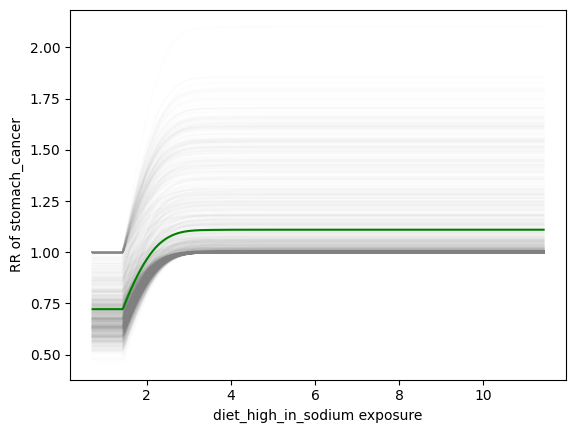

In [10]:
# Plot the relative risk functions
x_values = np.linspace(relative_risk_data.exposure.min() * 0.5, relative_risk_data.exposure.max() * 1.5, 500)
mean = np.zeros_like(x_values)

for i, function in enumerate(relative_risk_functions_no_clipping.values()):
    y_values = function(x_values)
    plt.plot(x_values, y_values, color="gray", alpha=0.01)
    mean += y_values

mean = mean / len(relative_risk_functions_no_clipping)
plt.plot(x_values, mean, color="green")
plt.gca().set_xlabel(f'{risk.name} exposure')
plt.gca().set_ylabel(f'RR of {cause.name}')
plt.show()

## Calculate a PAF and compare to GBD

In [11]:
# For the PAF, we need an exposure distribution.
# Currently, there is no easy way to do this with Vivarium tools
# without creating an artifact file!
fname = './salt.hdf'
!ls -halt $fname


# for this example, we will create a new artifact from scratch
!rm $fname
art = vi.Artifact(fname)

for measure in [
    'exposure',
    'exposure_standard_deviation',
    'exposure_distribution_weights',
]:
    df = vii.get_measure(risk, measure, location)
    key = f'risk_factor.{risk.name}.{measure}'
    art.write(key, df.loc[location]) # TODO: it is annoying that the location needs to be stripped from the dataframe

measure = 'distribution'
key = f'risk_factor.{risk.name}.{measure}'
art.write(key, 'ensemble')

-rw-rw-r-- 1 zmbc Domain Users 907K Jun 18 15:32 ./salt.hdf


/mnt/share/homes/zmbc/src/vivarium/src/vivarium/framework/artifact/artifact.py:69: UserWarning: No artifact found at salt.hdf. Building new artifact.
  warnings.warn(f"No artifact found at {path}. Building new artifact.")
2024-06-18 16:13:50.991 | WARNING  | vivarium_inputs.validation.shared:check_value_columns_boundary:82 - Data contains values below the expected boundary value (3.0).
/mnt/share/homes/zmbc/mambaforge/envs/vivarium/lib/python3.11/site-packages/vivarium_inputs/utilities.py:487: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{split_column_prefix}_end"] = [
2024-06-18 16:13:51.518 | WARNING  | vivarium_inputs.validation.raw:check_columns:2004 - Data returned extra columns: {'model_version_id'}.
2024-06-18 16:13:51.598 | WARNING  | vivari

In [12]:
age_group_definition = vii.utility_data.get_age_bins().set_index('age_group_id').loc[age_group_id]
age_group_definition

age_group_name    75 to 79
age_start             75.0
age_end               80.0
Name: 20, dtype: object

In [13]:
import vivarium_public_health.risks as vivarium_public_health_risks

import risk_distributions


In [14]:
index_cols = ['age_start', 'age_end', 'sex', 'year_start', 'year_end']
index_values = (age_group_definition.age_start, age_group_definition.age_end, sex, year, year+1)

pafs_no_clipping = []
pafs_clipping = []

for draw_id in range(500):
    sim = vi.InteractiveContext(
        components=[
            vivarium_public_health_risks.Risk(f'risk_factor.{risk.name}'),
        ],
        configuration={'input_data': {'artifact_path': fname, 'input_draw_number': draw_id}},
    )

    simulation_distribution = sim.list_components()['simulation_distribution.risk_factor.diet_high_in_sodium'].implementation

    weights = simulation_distribution.weights.data.set_index(index_cols).loc[index_values]
    parameters = {
        name: parameter.data.set_index(index_cols).loc[index_values] for name, parameter in simulation_distribution.parameters.items()
    }
    ensemble_distribution = risk_distributions.EnsembleDistribution(weights, parameters)

    np.random.seed(1234)
    # This is actually a sampling method!
    exposure_values = ensemble_distribution.ppf(np.clip(np.random.random(size=100_000), 0.0011, 0.998), np.random.random(size=100_000))

    rrs_clipping = relative_risk_functions_clipping[draw_id](exposure_values)
    pafs_clipping.append((rrs_clipping.mean() - 1) / rrs_clipping.mean())

    rrs_no_clipping = relative_risk_functions_no_clipping[draw_id](exposure_values)
    pafs_no_clipping.append((rrs_no_clipping.mean() - 1) / rrs_no_clipping.mean())


2024-06-18 16:13:53.002 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/share/homes/zmbc/src/scratch/salt.hdf.
2024-06-18 16:13:53.003 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2024-06-18 16:13:53.004 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.
2024-06-18 16:13:55.332 | WARNING  | simulation_1-resource_manager:256 - Resource column.age is not provided by any component but is needed to compute (value_source.diet_high_in_sodium.exposure).
2024-06-18 16:13:55.334 | WARNING  | simulation_1-resource_manager:256 - Resource column.sex is not provided by any component but is needed to compute (value_source.diet_high_in_sodium.exposure).
2024-06-18 16:13:55.726 | INFO     | simulation_2-artifact_manager:67 - Running simulation from artifact located at /mnt/share/homes/zmbc/src/scratch/salt.hdf.
2024-06-18 16:13:55.727 | INFO     | simulation_2-artif

<Axes: >

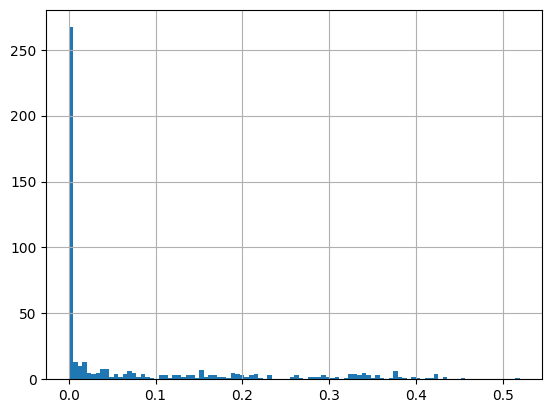

In [15]:
pd.Series(pafs_clipping).hist(bins=100)

In [16]:
pd.Series(pafs_clipping).describe()

count    5.000000e+02
mean     7.705723e-02
std      1.223740e-01
min      5.773160e-15
25%      1.820656e-05
50%      2.515528e-03
75%      1.222633e-01
max      5.191291e-01
dtype: float64

<Axes: >

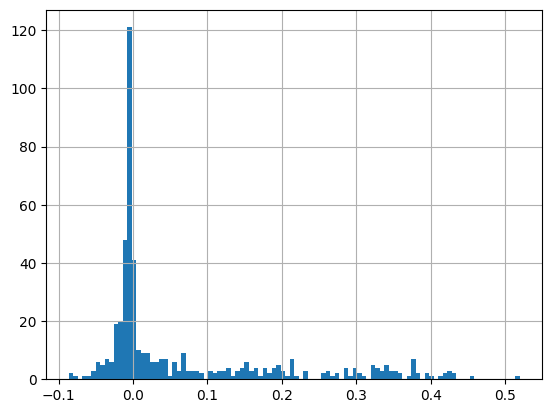

In [17]:
pd.Series(pafs_no_clipping).hist(bins=100)

In [18]:
pd.Series(pafs_no_clipping).describe()

count    500.000000
mean       0.069429
std        0.127296
min       -0.086454
25%       -0.007544
50%       -0.001245
75%        0.121385
max        0.519129
dtype: float64

In [19]:
gbd_pafs = vivarium_gbd_access.gbd.get_paf(risk.gbd_id, location_id, year)

In [20]:
gbd_pafs = gbd_pafs[
    (gbd_pafs.cause_id == cause.gbd_id) &
    (gbd_pafs.age_group_id == age_group_id) &
    (gbd_pafs.sex_id == sex_id) &
    (gbd_pafs.metric_id == 2) &
    (gbd_pafs.measure_id == 1)
].filter(like='draw').iloc[0].values

<Axes: >

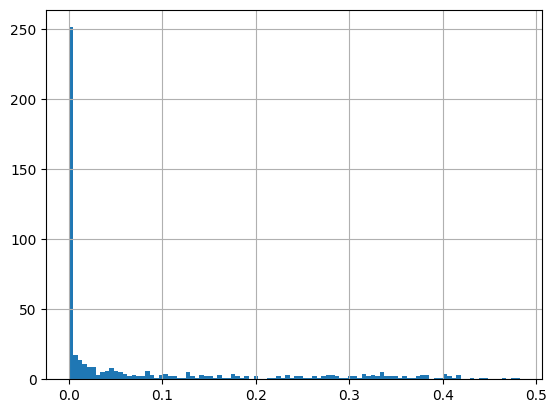

In [21]:
pd.Series(gbd_pafs).hist(bins=100)

In [22]:
pd.Series(gbd_pafs).describe()

count    5.000000e+02
mean     7.939280e-02
std      1.263711e-01
min     -3.227732e-10
25%      2.060816e-05
50%      4.528765e-03
75%      1.079007e-01
max      4.821714e-01
dtype: float64